In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

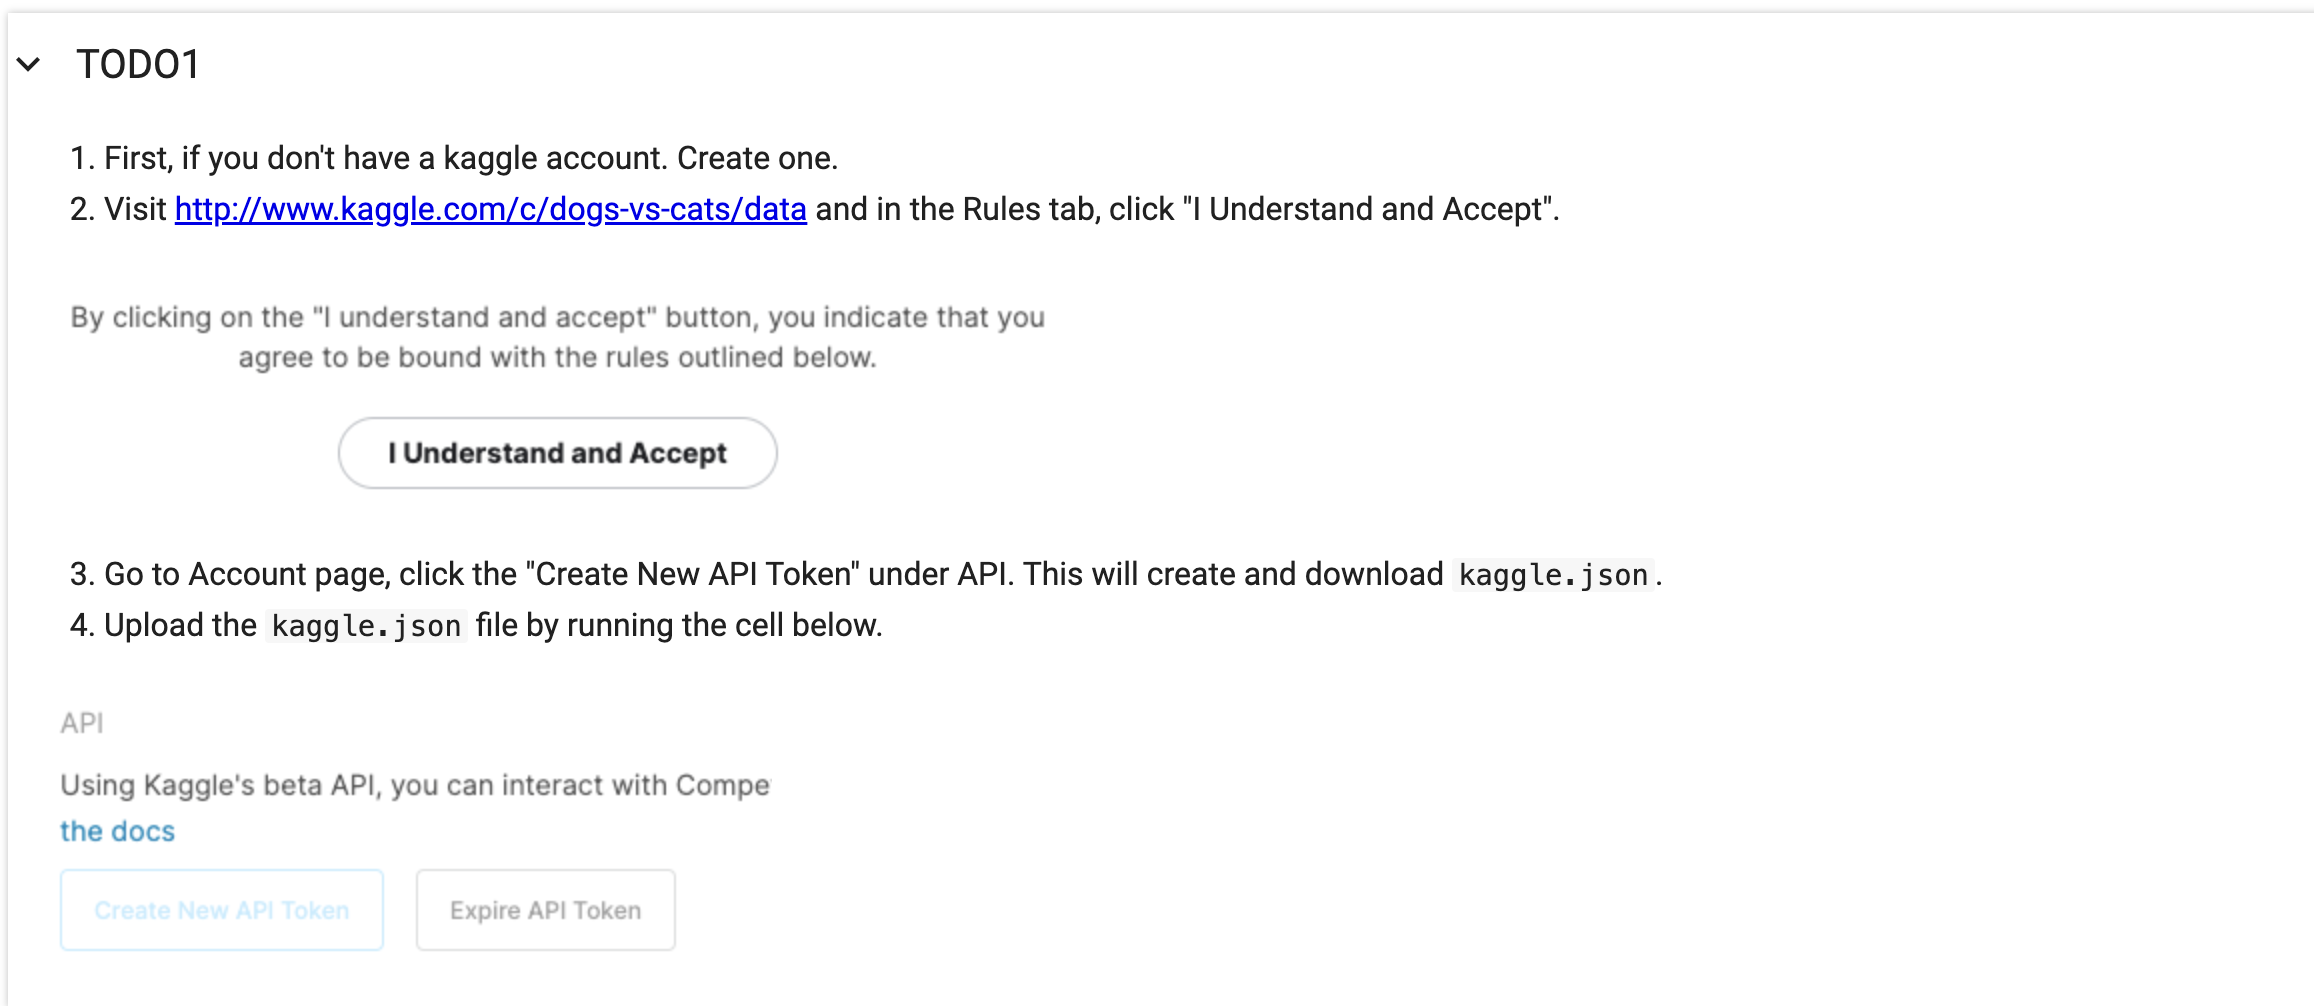

Create a Kaggle account. Click your profile and go to settings. Go to the API section and select "Create new token". Upload kaggle.json to runtime to download dataset.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d ks2019/nfl-images-zipped-fold-0

In [ ]:
# !unzip nfl-images-zipped-fold-0.zip

In [ ]:
# !pip install selectivesearch
# !pip install torch_snippets
# from torch_snippets import *
# import selectivesearch
# from skimage.segmentation import felzenszwalb

In [ ]:
# https://www.kaggle.com/competitions/nfl-player-contact-detection/data

!kaggle competitions download -c nfl-player-contact-detection

100% 3.82G/3.84G [00:42<00:00, 102MB/s]
100% 3.84G/3.84G [00:42<00:00, 97.3MB/s]


In [ ]:
!unzip nfl-player-contact-detection.zip

Archive:  nfl-player-contact-detection.zip
  inflating: sample_submission.csv   
  inflating: test/58168_003392_All29.mp4  
  inflating: test/58168_003392_Endzone.mp4  
  inflating: test/58168_003392_Sideline.mp4  
  inflating: test/58172_003247_All29.mp4  
  inflating: test/58172_003247_Endzone.mp4  
  inflating: test/58172_003247_Sideline.mp4  
  inflating: test_baseline_helmets.csv  
  inflating: test_player_tracking.csv  
  inflating: test_video_metadata.csv  
  inflating: train/58168_003392_All29.mp4  
  inflating: train/58168_003392_Endzone.mp4  
  inflating: train/58168_003392_Sideline.mp4  
  inflating: train/58172_003247_All29.mp4  
  inflating: train/58172_003247_Endzone.mp4  
  inflating: train/58172_003247_Sideline.mp4  
  inflating: train/58173_003606_All29.mp4  
  inflating: train/58173_003606_Endzone.mp4  
  inflating: train/58173_003606_Sideline.mp4  
  inflating: train/58174_001792_All29.mp4  
  inflating: train/58174_001792_Endzone.mp4  
  inflating: train/58174_00179

In [ ]:
from sklearn.metrics import matthews_corrcoef

labels = pd.read_csv("train_labels.csv", parse_dates=["datetime"])

ss = pd.read_csv("sample_submission.csv")

# Player tracking data
tr_tracking = pd.read_csv("train_player_tracking.csv", parse_dates=["datetime"])
te_tracking = pd.read_csv("test_player_tracking.csv", parse_dates=["datetime"])

# Baseline helmet detection labels
tr_helmets = pd.read_csv("train_baseline_helmets.csv")
te_helmets = pd.read_csv("test_baseline_helmets.csv")

# Video metadata with start/stop timestamps
tr_video_metadata = pd.read_csv("train_video_metadata.csv",parse_dates=["start_time", "end_time", "snap_time"],)

In [ ]:
tr_tracking_unique = tr_tracking.drop_duplicates(subset='nfl_player_id')

tr_helmets2 = pd.merge(tr_helmets, tr_tracking_unique[['nfl_player_id', 'position']], on='nfl_player_id', how='left')

In [ ]:
tr_helmets2

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height,position
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34,T
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33,FB
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35,G
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33,QB
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33,DT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3783611,58582_003121,58582,3121,Sideline,58582_003121_Sideline.mp4,842,52500,H13,497,24,316,25,WR
3783612,58582_003121,58582,3121,Sideline,58582_003121_Sideline.mp4,842,52493,V32,914,23,356,26,FS
3783613,58582_003121,58582,3121,Sideline,58582_003121_Sideline.mp4,842,45009,V97,30,29,446,23,DE
3783614,58582_003121,58582,3121,Sideline,58582_003121_Sideline.mp4,842,46155,H89,750,18,338,26,TE


In [ ]:
import os
import cv2
import subprocess
from IPython.display import Video, display
import pandas as pd


def video_with_helmets(
    video_path: str, baseline_boxes: pd.DataFrame, verbose=True
) -> str:
    """
    Annotates a video with baseline model boxes and labels.
    """
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)  # Black
    video_name = os.path.basename(video_path)
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy()

    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "labeled_" + video_name
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(
        tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    )

    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        # We need to add 1 to the frame count to match the label frame index
        # that starts at 1
        frame += 1

        # Let's add a frame index to the video so we can track where we are
        img_name = video_name.replace(".mp4", "")
        cv2.putText(
            img,
            img_name,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        cv2.putText(
            img,
            str(frame),
            (1280 - 90, 720 - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        # Now, add the boxes
        boxes = baseline_boxes.query("video == @video_name and frame == @frame")
        for box in boxes.itertuples(index=False):
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                HELMET_COLOR,
                thickness=1,
            )
            cv2.putText(
                img,
                box.position,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                HELMET_COLOR,
                thickness=1,
            )

        output_video.write(img)
    output_video.release()
    # Not all browsers support the codec, we will re-load the file at tmp_output_path
    # and convert to a codec that is more broadly readable using ffmpeg
    if os.path.exists(output_path):
        os.remove(output_path)
    subprocess.run(
        [
            "ffmpeg",
            "-i",
            tmp_output_path,
            "-crf",
            "18",
            "-preset",
            "veryfast",
            "-hide_banner",
            "-loglevel",
            "error",
            "-vcodec",
            "libx264",
            output_path,
        ]
    )
    os.remove(tmp_output_path)

    return output_path

In [ ]:
example_video = "train/58173_003606_Sideline.mp4"
output_video = video_with_helmets(example_video, tr_helmets2)

frac = 0.65  # scaling factor for display
display(
    Video(data=output_video, embed=True, height=int(720 * frac), width=int(1280 * frac))
)

In [ ]:
import matplotlib.patches as patches
import matplotlib.pylab as plt

def create_football_field(
    linenumbers=True,
    endzones=True,
    figsize=(12, 6.33),
    line_color="black",
    field_color="white",
    ez_color=None,
    ax=None,
    return_fig=False,
):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """

    if ez_color is None:
        ez_color = field_color

    rect = patches.Rectangle(
        (0, 0),
        120,
        53.3,
        linewidth=0.1,
        edgecolor="r",
        facecolor=field_color,
        zorder=0,
    )

    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)
    ax.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color=line_color)

    # Endzones
    if endzones:
        ez1 = patches.Rectangle(
            (0, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor=line_color,
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ez2 = patches.Rectangle(
            (110, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor=line_color,
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ax.add_patch(ez1)
        ax.add_patch(ez2)

    ax.axis("off")
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(
                x,
                5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color=line_color,
            )
            ax.text(
                x - 0.95,
                53.3 - 5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color=line_color,
                rotation=180,
            )
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color=line_color)
        ax.plot([x, x], [53.0, 52.5], color=line_color)
        ax.plot([x, x], [22.91, 23.57], color=line_color)
        ax.plot([x, x], [29.73, 30.39], color=line_color)

    border = patches.Rectangle(
        (-5, -5),
        120 + 10,
        53.3 + 10,
        linewidth=0.1,
        edgecolor="orange",
        facecolor=line_color,
        alpha=0,
        zorder=0,
    )
    ax.add_patch(border)
    ax.set_xlim((-5, 125))
    ax.set_ylim((-5, 53.3 + 5))

    if return_fig:
        return fig, ax
    else:
        return ax

In [ ]:
game_play = "58168_003392"
example_tracks = tr_tracking.query("game_play == @game_play and step == 0")
ax = create_football_field()
for team, d in example_tracks.groupby("team"):
    ax.scatter(
        d["x_position"],
        d["y_position"],
        label=team,
        s=65,
        lw=1,
        edgecolors="black",
        zorder=5,
    )
ax.legend().remove()
ax.set_title(f"Tracking data for {game_play}: at step 0", fontsize=15)
plt.show()

In [ ]:
tr_helmets2['position'].unique()

array(['T', 'FB', 'G', 'QB', 'DT', 'SS', 'OLB', 'TE', 'RB', 'FS', 'C',
       'ILB', 'DE', 'CB', 'WR', 'P', 'LS', 'MLB', 'LB', 'DB', 'DL', 'NT',
       'OG', 'OT', 'SAF', 'K', 'S', 'HB'], dtype=object)

In [ ]:
import os
import cv2
import subprocess
import pandas as pd
import numpy as np

def is_defensive_position(position):
    """
    Check if the given player position is classified as defensive based on specific mappings.

    Args:
        position (str): Player position to be checked.

    Returns:
        bool: True if the position is defensive, False otherwise.
    """
    defensive_positions = [
        'CB', 'DE', 'FS', 'ILB', 'OLB', 'NT', 'DT', 'MLB',
        'SS', 'LB', 'SAF', 'DB', 'S', 'DL'
    ]
    return position in defensive_positions

def video_with_helmets_and_qb_distance(
    video_path: str, baseline_boxes: pd.DataFrame, verbose=True
) -> str:
    """
    Annotates a video with baseline model boxes, labels, and QB distance-based color annotations using helmet predictions.

    Args:
        video_path (str): Path to the video file.
        baseline_boxes (pd.DataFrame): DataFrame containing baseline model boxes and player tracking data.
        verbose (bool): Whether to print verbose output.

    Returns:
        str: Path to the annotated video file.
    """
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)  # Black
    DEF_COLOR = (0, 0, 255)
    QB_COLOR = (255, 0, 0)

    video_name = os.path.basename(video_path)
    if verbose:
        print(f"Running for {video_name}")

    # Open video capture
    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "annotated_" + video_name
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(
        tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    )

    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1

        # Filter baseline boxes for the current frame
        frame_boxes = baseline_boxes[(baseline_boxes['video'] == video_name) & (baseline_boxes['frame'] == frame)]

        # Annotate baseline boxes
        for box in frame_boxes.itertuples(index=False):
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                HELMET_COLOR,
                thickness=1,
            )
            cv2.putText(
                img,
                box.position,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                HELMET_COLOR,
                thickness=1,
            )

        # Extract QB position for the frame (assuming QB is tagged as 'QB' in position column)
        qb_box = frame_boxes[frame_boxes['position'] == 'QB']
        if not qb_box.empty:
            qb_x = int(qb_box['left'].iloc[0])
            qb_y = int(qb_box['top'].iloc[0])
            qb_width = int(qb_box['width'].iloc[0])
            qb_height = int(qb_box['height'].iloc[0])

            # Highlight QB with the specified color
            cv2.rectangle(img, (qb_x, qb_y), (qb_x + qb_width, qb_y + qb_height), QB_COLOR, 2)

            # Find defensive players and calculate distances to the QB
            closest_defensive_distance = float('inf')
            closest_defensive_player = None

            # Initialize variable to track if any offensive player is closer to the QB
            offensive_player_closer = False

            # Loop through each player box to find the closest defensive player to the QB
            for box in frame_boxes.itertuples(index=False):
                x = int(box.left)
                y = int(box.top)
                width = int(box.width)
                height = int(box.height)
                position = box.position

                if is_defensive_position(position):
                    # Calculate distance to QB
                    distance_to_qb = np.sqrt((x - qb_x)**2 + (y - qb_y)**2)

                    # Check if this defensive player is the closest and no offensive player is closer
                    if distance_to_qb < closest_defensive_distance and not offensive_player_closer:
                        # Check distances to all offensive players
                        offensive_player_closer = any(
                            np.sqrt((ox - qb_x)**2 + (oy - qb_y)**2) < distance_to_qb
                            for ox, oy, ow, oh, op in zip(
                                frame_boxes['left'], frame_boxes['top'],
                                frame_boxes['width'], frame_boxes['height'],
                                frame_boxes['position']
                            )
                            if not is_defensive_position(op) and op != 'QB'
                        )

                        if not offensive_player_closer:
                            closest_defensive_distance = distance_to_qb
                            closest_defensive_player = (x, y, width, height)

            # Highlight the closest defensive player to the QB if no closer offensive player
            if closest_defensive_player:
                x, y, width, height = closest_defensive_player
                cv2.rectangle(img, (x, y), (x + width, y + height), DEF_COLOR, 2)


        # Write annotated frame to output video
        output_video.write(img)

    # Release video capture and writer
    vidcap.release()
    output_video.release()

    # Convert video codec using ffmpeg
    subprocess.run(["ffmpeg", "-i", tmp_output_path, "-crf", "18", "-preset", "veryfast", "-hide_banner", "-loglevel", "error", "-vcodec", "libx264", output_path])
    os.remove(tmp_output_path)

    return output_path

In [ ]:
# Example usage with your DataFrame `tr_tracking` and video path
game_play = "58168_003392"
example_video = f"train/{game_play}_Sideline.mp4"

# Call the function to process the video with QB distance annotation
annotated_video_path = video_with_helmets_and_qb_distance(example_video, tr_helmets2)

# Display the annotated video
frac = 0.65
display(
    Video(data=annotated_video_path, embed=True, height=int(720 * frac), width=int(1280 * frac))
)